In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection, multipletests
import os

os.chdir("/labs/abrunet1/Eric/JasonPaper")

In [2]:
# read in protein intensities
df = pd.read_excel("MS-06 Protein Intensities.xlsx")

In [3]:
# reformat dataframe

df_var = df[['Peptides',
       'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]',
       'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]',
       'Mol. weight [kDa]', 'Q-value', 'Score', 'Intensity', 'MS/MS count',
       'Protein IDs', 'Majority protein IDs', 'id', 'Gene name',
       'Protein name']].copy()
df_var.index = df_var["Gene name"]

df_intensities = df.drop(['Peptides',
       'Razor + unique peptides', 'Unique peptides', 'Sequence coverage [%]',
       'Unique + razor sequence coverage [%]', 'Unique sequence coverage [%]',
       'Mol. weight [kDa]', 'Q-value', 'Score', 'Intensity', 'MS/MS count',
       'Protein IDs', 'Majority protein IDs', 'id', 'Gene name',
       'Protein name'], axis=1)
df_intensities = df_intensities.T
df_intensities.columns = df_var["Gene name"]


# make anndata
adata = ad.AnnData(X=df_intensities, var=df_var)


# create obs from names
locations = []
ages = []
replicates = []

for label in df_intensities.index:
    
    splitted = label.split("_")
    
    if "N2" in label:
        locations.append(splitted[0])
        ages.append(splitted[2])
        replicates.append(splitted[1])
        
    elif "Blank" in label:
        locations.append(splitted[0])
        ages.append(splitted[1])
        replicates.append(splitted[1])
        
    else:
        locations.append(splitted[0])
        ages.append(splitted[1])
        replicates.append(splitted[2])
        
adata.obs["location"] = locations
adata.obs["age"] = ages
adata.obs["replicate"] = replicates

/local/scratch/edsun/slrmtmp.44050012/ipykernel_28985/3617655527.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=df_intensities, var=df_var)
/home/edsun/.conda/envs/merfish/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Data normalization and imputation

In [4]:
# normalized total intensity
#adata.X = adata.X / np.sum(adata.X, axis=1).reshape((adata.shape[0],1)) * 1e5
sc.pp.normalize_total(adata, target_sum=1e10)

In [5]:
# # save normalized data
# df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
# df.to_csv("normalized_data.csv")

In [6]:
# log2 transform with pseudocount
#adata.X  = np.log2(adata.X + 1)
sc.pp.log1p(adata, base=2)

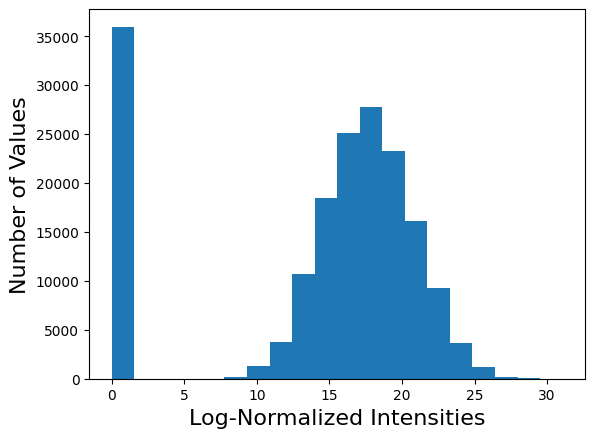

In [7]:
plt.hist(adata.X.flatten(), bins=20)
plt.xlabel("Log-Normalized Intensities", fontsize=16)
plt.ylabel("Number of Values", fontsize=16)
plt.show()

In [12]:
# # save normalized data
# df = pd.DataFrame(adata.X, columns=adata.var_names, index=adata.obs_names)
# df.to_csv("log2_normalized_data.csv")

## Raw data visualization with PCA

In [8]:
def drop_zeros (adata, zero_perc=1.0):
    '''
    Drop genes/columns with too many zeros
    '''
    
    adata = adata[:, np.count_nonzero(adata.X, axis=0) >= zero_perc*adata.shape[0]]
    
    return (adata)

def impute_zeros (x, method="random_normal"):
    '''
    Impute zero values for an array x
    '''
    x_imp = x.copy()
    
    if method == "random":
        for j in range(x.shape[1]):
            zero_mask = x[:,j]==0
            np.random.seed(444)
            rand_draws = np.random.choice(x[~zero_mask,j], zero_mask.sum(), replace=True)
            x_imp[zero_mask,j] = rand_draws
            
    if method == "random_normal":
        for j in range(x.shape[1]):
            zero_mask = x[:,j]==0
            np.random.seed(0)
            rand_draws = np.random.normal(np.mean(x[~zero_mask,j]),
                                          np.std(x[~zero_mask,j]),
                                          zero_mask.sum())
            x_imp[zero_mask,j] = rand_draws
    
    return (x_imp)

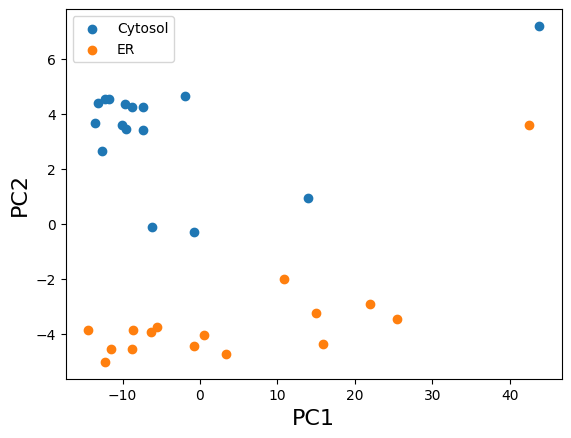

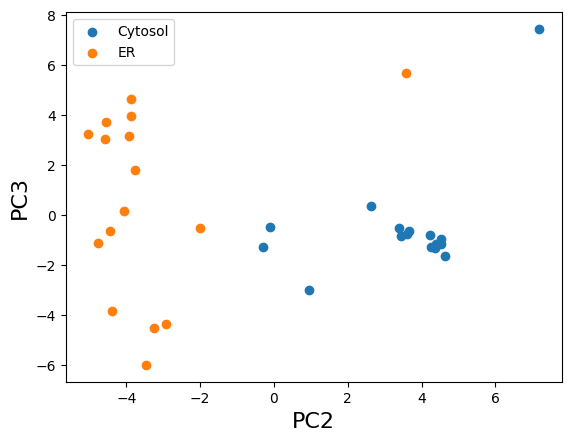

In [9]:
scaler = StandardScaler()
pca = PCA(n_components=5, svd_solver='full')

# standardize columns
x = drop_zeros(adata).X
#x = impute_zeros(x)
x = scaler.fit_transform(x)
xpc = pca.fit_transform(x)

# plot by location
for loca in ["Cytosol", "ER"]:
    mask = adata.obs.location==loca
    plt.scatter(xpc[mask,0], xpc[mask,1], label=loca)
plt.xlabel("PC1", fontsize=16)
plt.ylabel("PC2", fontsize=16)
plt.legend(loc='best')
plt.show()

for loca in ["Cytosol", "ER"]:
    mask = adata.obs.location==loca
    plt.scatter(xpc[mask,1], xpc[mask,2], label=loca)
plt.xlabel("PC2", fontsize=16)
plt.ylabel("PC3", fontsize=16)
plt.legend(loc='best')
plt.show()

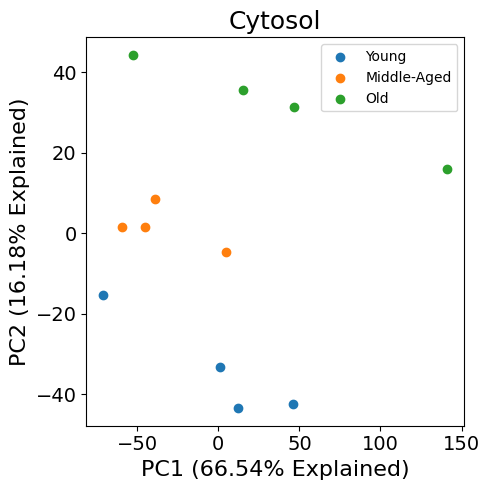

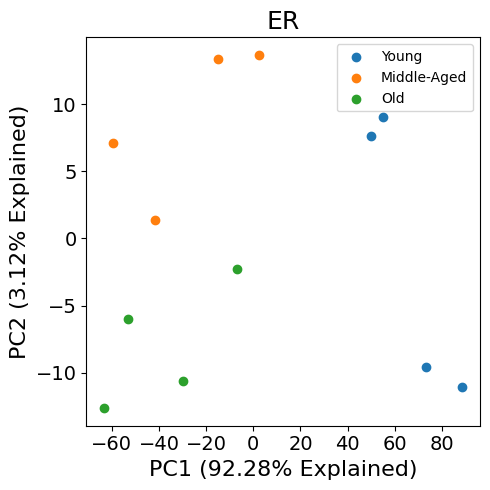

In [10]:
# split by ER and Cytosol first

for loca in ["Cytosol", "ER"]:
    
    sub_adata = adata[adata.obs.location==loca]
    
    # subset only replicates
    sub_adata = sub_adata[sub_adata.obs.replicate.isin(["1","2","3","4"])]
        
    scaler = StandardScaler()
    pca = PCA(n_components=5, svd_solver='full')

    # standardize columns
    x = drop_zeros(sub_adata).X
    #x = impute_zeros(x)
    x = scaler.fit_transform(x)
    xpc = pca.fit_transform(x)

    # plot by age
    plt.figure(figsize=(5,5))
    for age in ["Young", "Middle-Aged", "Old"]:
        mask = sub_adata.obs.age==age
        plt.scatter(xpc[mask,0], xpc[mask,1], label=age)
    plt.title(loca, fontsize=18)
    plt.xlabel(f"PC1 ({round(pca.explained_variance_ratio_[0]*100, 2)}% Explained)", fontsize=16)
    plt.ylabel(f"PC2 ({round(pca.explained_variance_ratio_[1]*100, 2)}% Explained)", fontsize=16)
    plt.legend(loc='best')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig(f"plots/pca/{loca}.pdf", bbox_inches='tight')
    plt.show()

## Correlation matrices

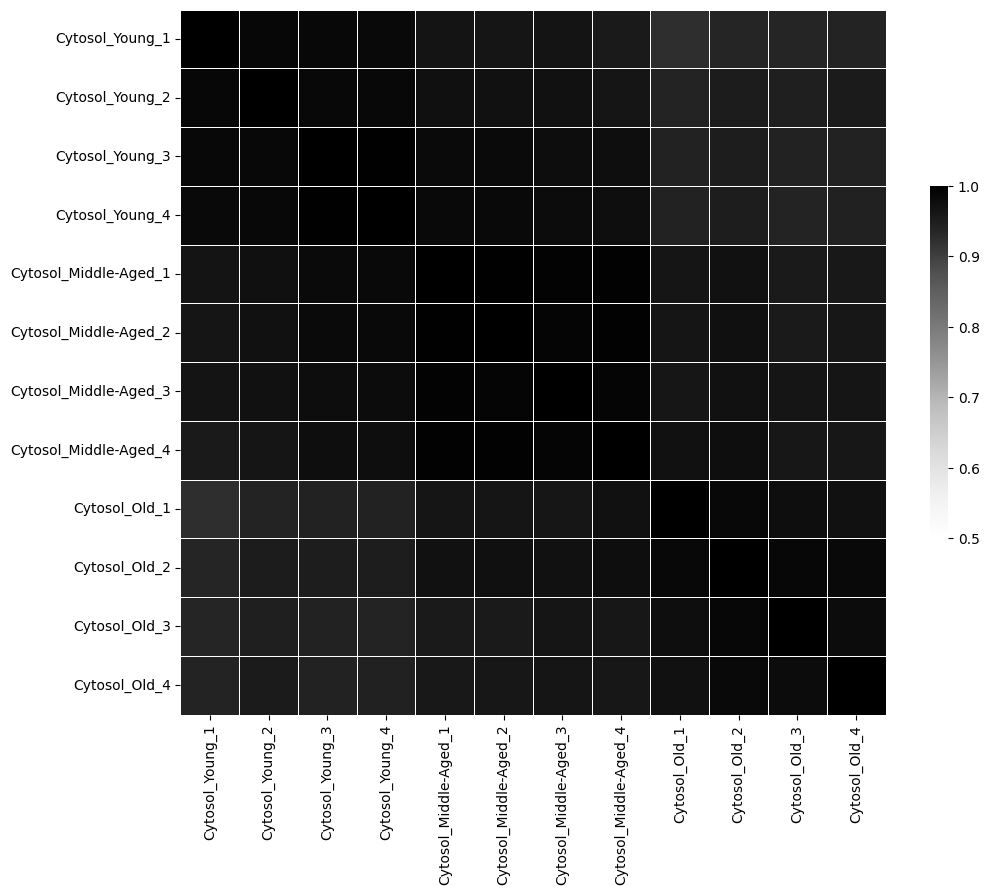

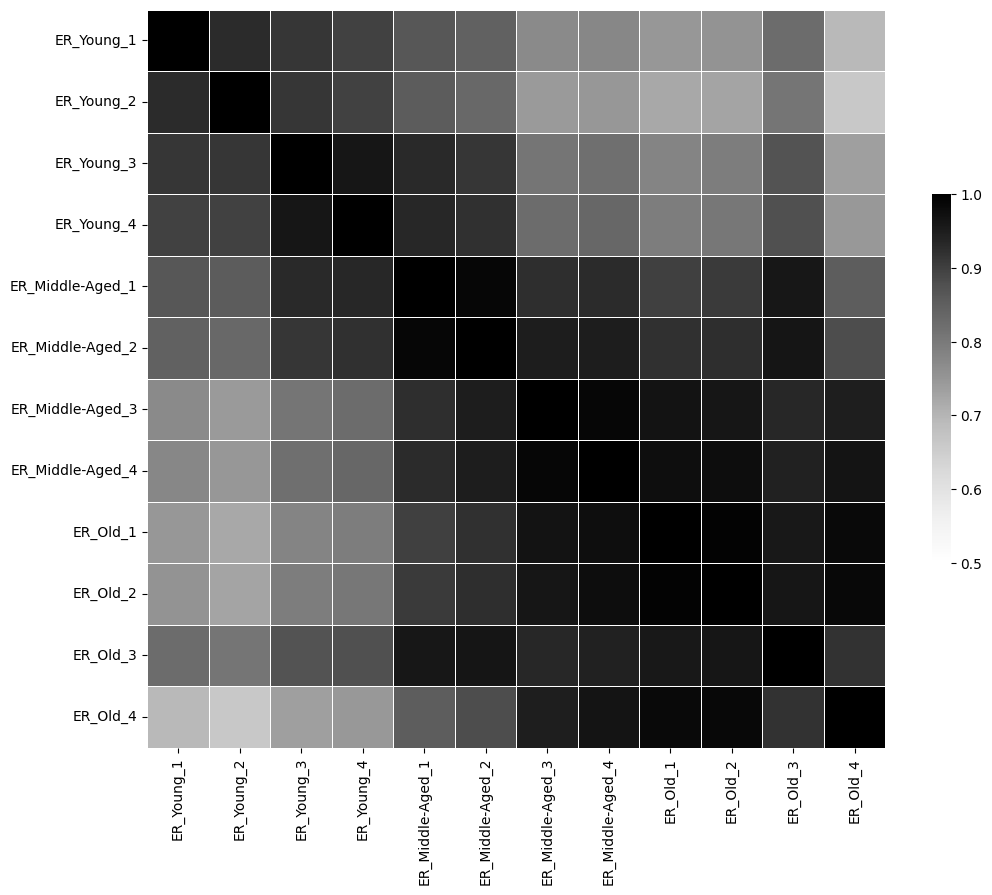

In [27]:
for loca in ["Cytosol", "ER"]:
    
    sub_adata = adata[adata.obs.location==loca]
    sub_adata = sub_adata[sub_adata.obs.replicate.isin(["1","2","3","4"])]

    # Compute the correlation matrix
    corr = pd.DataFrame(drop_zeros(sub_adata).X.T,columns=sub_adata.obs_names).corr()

    # Generate a mask for the upper triangle
    #mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap="Greys", vmin=0.5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.tight_layout()
    plt.savefig(f"plots/correlation/{loca}.pdf", bbox_inches='tight')
    plt.show()

## Statistical testing

In [10]:
comparisons = ["Old_Young", "Old_Middle-Aged", "Middle-Aged_Young"]

t_stats = []
p_vals = []
logfcs = []
percnotzero = []
column_names = []

# ----------------------------------------

for loca in ["Cytosol", "ER"]:
    
    sub_adata = adata[adata.obs.location==loca]
    
    for comparison in comparisons:
        
        tst = []
        pva = []
        logfc = []
        pnmiss = []
        
        # get groups to compare
        age1 = comparison.split("_")[0]
        age2 = comparison.split("_")[1]
        
        # test each protein
        for protein in adata.var_names:
            
            # get expression of replicates
            x = sub_adata[(sub_adata.obs.age==age1)&(sub_adata.obs.replicate.isin(["1","2","3","4"])),protein].X.toarray().flatten()
            y = sub_adata[(sub_adata.obs.age==age2)&(sub_adata.obs.replicate.isin(["1","2","3","4"])),protein].X.toarray().flatten()
            
            # Welch's t-test
            t, p = ttest_ind(x, y, equal_var=False)
            
            # Log2 fold change -- map to raw intensities first from log2+1 transform
            lfc = np.log2(np.mean(np.power(2,x)-1)/np.mean(np.power(2,y)-1))
            
            # percent missing (zeros)
            pnm = (np.count_nonzero(x) + np.count_nonzero(y)) / (len(x) + len(y))
            
            tst.append(t)
            pva.append(p)
            logfc.append(lfc)
            pnmiss.append(pnm)
            
        t_stats.append(tst)
        p_vals.append(pva)
        logfcs.append(logfc)
        percnotzero.append(pnmiss)
        
        column_names.append(loca+"_"+comparison)

/local/scratch/edsun/slrmtmp.43550580/ipykernel_29783/3915256908.py:37: RuntimeWarning: invalid value encountered in float_scalars
  lfc = np.log2(np.mean(np.power(2,x)-1)/np.mean(np.power(2,y)-1))
/local/scratch/edsun/slrmtmp.43550580/ipykernel_29783/3915256908.py:37: RuntimeWarning: divide by zero encountered in float_scalars
  lfc = np.log2(np.mean(np.power(2,x)-1)/np.mean(np.power(2,y)-1))
/local/scratch/edsun/slrmtmp.43550580/ipykernel_29783/3915256908.py:37: RuntimeWarning: divide by zero encountered in log2
  lfc = np.log2(np.mean(np.power(2,x)-1)/np.mean(np.power(2,y)-1))


In [11]:
# P-value FDR correction

adjusted_p_vals = []

for i in range(len(p_vals)):
    
    # build mask for finite values
    parr = np.array(p_vals[i])
    valmask = np.isfinite(parr)
    
    # perform multiple correction
    rej, pvals, asid, abon = multipletests(parr[valmask], alpha=0.05, method='fdr_bh')
    
    # get new pvalues
    parr[valmask] = pvals
    adjusted_p_vals.append(parr)

In [12]:
# make column names
all_columns = [c+"_tStat" for c in column_names] + [c+"_PValue" for c in column_names] + [c+"_PValueAdjFDR" for c in column_names] + [c+"_log2FC" for c in column_names] + [c+"_FracNonzero" for c in column_names]

# make dataframe for results and save
stats_df = pd.DataFrame(np.concatenate((np.vstack(t_stats),np.vstack(p_vals),np.vstack(adjusted_p_vals),np.vstack(logfcs),np.vstack(percnotzero))).T,
                        columns=all_columns)

stats_df.insert(0, "Gene", adata.var_names)
stats_df.to_csv("welch_ttest_results_normalized.csv", index=None)
#stats_df.to_csv("welch_ttest_results.csv", index=None)

In [32]:
# ACP7
#sorted_df[sorted_df['Gene']=="CELE_F21A3.11"]

In [33]:
# VAPA
#sorted_df[sorted_df['Gene']=="CELE_F53B6.4"]

## Volcano Plot

In [8]:
tag = "" # "", "_normalized"

stats_df = pd.read_csv(f"welch_ttest_results{tag}.csv")

In [ ]:
nonzero_frac_min = 1.0
pvalcutoff = 0.1
abslog2fc = 0.1

pval_column_tag = "_PValueAdjFDR"
#pval_column_tag = "_PValue"

target_genes = ["CELE_F21A3.11", "CELE_F53B6.4"]


#--------------------------------------------------------------------------------
comparisons = ["Old_Young", "Old_Middle-Aged", "Middle-Aged_Young"]

for loca in ["Cytosol", "ER"]:
    
    for comparison in comparisons:
        
        # get column
        colname = loca+"_"+comparison
        
        # filter
        filtered_stats_df = stats_df[stats_df[colname+"_FracNonzero"] >= nonzero_frac_min]
        
        # significant masking
        sig_mask = (filtered_stats_df[colname+pval_column_tag] <= pvalcutoff) & (np.abs(filtered_stats_df[colname+"_log2FC"]) >= abslog2fc)
        target_mask = filtered_stats_df["Gene"].isin(target_genes)
        
        plt.figure(figsize=(5,5))
        plt.title(colname, fontsize=18)
        plt.scatter(filtered_stats_df[colname+"_log2FC"], -np.log10(filtered_stats_df[colname+pval_column_tag]), s=1, c="0.5")
        plt.scatter(filtered_stats_df[colname+"_log2FC"].values[sig_mask], -np.log10(filtered_stats_df[colname+pval_column_tag])[sig_mask], s=3, c="r")
        plt.scatter(filtered_stats_df[colname+"_log2FC"].values[target_mask], -np.log10(filtered_stats_df[colname+pval_column_tag])[target_mask], s=50, c="g")
        plt.xlabel("Log2 Fold Change", fontsize=16)
        plt.ylabel("Negative Log10 Adjusted P-Value", fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout()
        plt.savefig(f"plots/volcano/{colname+tag}.pdf", bbox_inches='tight')
        plt.show()